In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
!pip install scipy --upgrade
import scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#read Dataset
df_raw = pd.read_csv('vgames2.csv', index_col=0, na_values=['Unknown', 'Misc'])
num_df_before = df_raw.shape[0]

#refine Year
df_raw.loc[df_raw.Year<=22,'Year'] += 2000
df_raw.loc[df_raw.Year<=99,'Year'] += 1900

#refine Sales data
sales_col = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for col in sales_col:
  df_raw[col] = df_raw[col].str.replace('M','')
  df_raw[col] = [(
      ele.replace('K', '') if re.match('.*K', ele) else round(float(ele) * 1000, 3)
      ) for ele in df_raw[col]]

#domain Knowlege
df_raw.Genre = df_raw.Genre.str.replace('Platform','Action')

#sort
df_raw = df_raw.sort_values(['Name', 'Platform']).reset_index(drop= True)
(df_raw.isna()).sum()

Name              0
Platform          0
Year            271
Genre          1784
Publisher       261
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
dtype: int64

In [3]:
def del_region_sale(df_test:pd.DataFrame):
  idx = df_test['Name'].str.contains('\(.*Sale|\(.*sale')
  df_ret = df_test[idx].copy()
  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    x = name.find(r'(')
    if name[x-1] == ' ': x -= 1
    df_ret.loc[i, 'Name'] = name[:x]
  
  return df_ret

def unite_dupl(df_test:pd.DataFrame):
  df_ret = df_test.drop_duplicates(subset= ['Name', 'Platform']).copy()
  df_raw = df_test.loc[df_test.duplicated(subset= ['Name', 'Platform'], keep= False)==True,:]
  df_add = df_raw.loc[df_raw.duplicated(subset= ['Name', 'Platform'])==True,:].copy()

  for i in df_add.index:
    name = df_add.loc[i, 'Name']
    df_sub = df_raw.query(f'Name == "{name}"')
    df_add.loc[i, sales_col] = np.sum(df_sub[sales_col].T)

  df_ret.update(df_add)
  return df_ret

def update_dupl_na(df_test, df_raw, col):
  def make_dupl(df):
    return df[df.duplicated(subset= 'Name', keep= False) == True].sort_values('Name')
    
  df_not_NA = make_dupl(df_raw).dropna(subset= [col])
  df_NA = make_dupl(df_test).loc[df_test[col].isna() == True,:].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    df_sub = df_not_NA.query(f'Name == "{name}"')
    if  df_sub.shape[0] > 0:
      df_NA.loc[i, col] = df_sub[col].iloc[0]

  return df_NA

def year_in_title(df):
  df_ret = df[df.Name.str.contains('\d{4}')].\
              loc[df.Year.isna() == True, :].copy()
  for i in df_ret.index:
    name = df.loc[i, 'Name']
    df_ret.loc[i, 'Year'] = int(name[-4:])

  return df_ret

def col_in_title(df_test, df_raw, col):
  df_ret = df_test[df_test[col].isna() == True].copy()
  col_unique = df_raw.dropna(subset = [col])[col].unique()

  for i in df_ret.index:
    name = df_ret.loc[i, 'Name']
    for col_u in col_unique:
      if name.find(col_u) >= 0:
        df_ret.loc[i, col] = col_u
        break
  
  return df_ret

def col_in_series(df_test, df_raw, col):
  df_not_NA = df_raw.dropna(subset= [col])
  df_NA = df_test[df_test[col].isna() == True].copy()

  for name in df_NA.Name.unique():
    name_x = name
    x = name.find(':')
    if x > 0: name_x = name[:x]
    idx = df_NA[df_NA.Name.str.contains(name_x)]
    df_sub = df_not_NA[df_not_NA.Name.str.contains(name_x)]

    if df_sub[col].unique().shape[0] == 1:
      df_NA.loc[idx, col] = df_sub[col].iloc[0]

    return df_NA


def gen_in_title_manual(df_test, df_raw, sub, gen=None):
  df_NA = df_test[df_test['Genre'].isna() == True].copy()
  
  if gen is None:
    df_not_NA = df_raw.dropna(subset= ['Genre']).loc[df_raw.Name.str.contains(sub)]
  
    if df_not_NA.shape[0] > 0:
      df_NA.loc[df_raw.Name.str.contains(sub), 'Genre'] = df_not_NA['Genre'].iloc[0]
  else:
     df_NA.loc[df_raw.Name.str.contains(sub), 'Genre'] = gen
     
  return df_NA

def clue_year(df_test:pd.DataFrame, df_raw:pd.DataFrame):
  df_not_NA = df_raw.dropna(subset= ['Year'])
  df_NA = df_test[df_test.Year.isna() == True].copy()

  for i in df_NA.index:
    name = df_NA.loc[i, 'Name']
    idx = df_NA.query(f'Name == "{name}"').index
    min = np.min(df_not_NA.Year)
    max = np.max(df_not_NA.Year)
    
    publisher = df_NA.loc[i,'Publisher']
    if publisher in df_raw.Publisher.unique():
      df_p = df_not_NA.query(f'Publisher == "{publisher}"')
      if df_p.shape[0] > 0:
        raw_p = df_p.Year

        min = np.max([min, np.min(raw_p)])
        max = np.min([max, np.min(raw_p)])

    for j in idx:
      platform = df_NA.Platform.loc[j]
      raw_p = df_not_NA.query(f'Platform == "{platform}"').Year
      
      min = np.max([min, np.min(raw_p)])
      max = np.min([max, np.min(raw_p)])

    df_NA.loc[i, 'Year'] = np.mean([min, max]).round(0)

  return df_NA

In [4]:
#make EDA dataframe
df = df_raw.loc[df_raw.Name.str.contains('\(.*wrong') == False].copy()

#find if it is separated
df.update(del_region_sale(df))
df.sort_values(['Name', 'Platform', 'Year', 'Genre', 'Publisher'], inplace = True)
df_raw.update(df)

In [5]:
#NA control
df.update(update_dupl_na(df, df_raw,'Year'))
df.update(update_dupl_na(df, df_raw,'Genre'))
df.update(update_dupl_na(df, df_raw,'Publisher'))

df.update(year_in_title(df))
df.update(col_in_title(df, df_raw, 'Genre'))
df.update(col_in_title(df, df_raw, 'Publisher'))

df.update(col_in_series(df, df_raw, 'Genre'))
df.update(col_in_series(df, df_raw, 'Publisher'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16596 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16596 non-null  object 
 1   Platform     16596 non-null  object 
 2   Year         16460 non-null  float64
 3   Genre        14867 non-null  object 
 4   Publisher    16420 non-null  object 
 5   NA_Sales     16596 non-null  object 
 6   EU_Sales     16596 non-null  object 
 7   JP_Sales     16596 non-null  object 
 8   Other_Sales  16596 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [6]:
#NA control manually
df.update(gen_in_title_manual(df, df_raw, 'Dance ?Dance'))
df.update(gen_in_title_manual(df, df_raw, 'Pokemon .*/Pokemon .*'))
df.update(gen_in_title_manual(df, df_raw, 'Amnesia'))
df.update(gen_in_title_manual(df, df_raw, 'Animal Crossing'))
df.update(gen_in_title_manual(df, df_raw, 'Momotarou Dentetsu'))
df.update(gen_in_title_manual(df, df_raw, 'Myth Makers'))
df.update(gen_in_title_manual(df, df_raw, 'The Sims'))
df.update(gen_in_title_manual(df, df_raw, 'Minecraft'))
df.update(gen_in_title_manual(df, df_raw, 'Final Fantasy'))

df.update(gen_in_title_manual(df, df_raw, 'Guitar|guitar'))
df.update(gen_in_title_manual(df, df_raw, 'Mahjong'))
df.update(gen_in_title_manual(df, df_raw, 'Chess|chess'))

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16596 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16596 non-null  object 
 1   Platform     16596 non-null  object 
 2   Year         16460 non-null  float64
 3   Genre        14984 non-null  object 
 4   Publisher    16420 non-null  object 
 5   NA_Sales     16596 non-null  object 
 6   EU_Sales     16596 non-null  object 
 7   JP_Sales     16596 non-null  object 
 8   Other_Sales  16596 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.8+ MB


In [7]:
#replace NAs
df.Genre.fillna('Misc', inplace= True)
df.update(clue_year(df, df_raw))
df.Publisher.fillna('Unknown', inplace= True)
df = unite_dupl(df)

df[['Platform', 'Genre', 'Publisher']] = df[['Platform', 'Genre', 'Publisher']].astype('category')
df[sales_col] = df[sales_col].astype(int)

#Data Featuring
df['Total_Sales'] = np.sum(df[sales_col].T)
df = df.convert_dtypes()
df.info()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return reduction(axis=axis, out=out, **passkwargs)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16484 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         16484 non-null  string  
 1   Platform     16484 non-null  category
 2   Year         16484 non-null  Int64   
 3   Genre        16484 non-null  category
 4   Publisher    16484 non-null  category
 5   NA_Sales     16484 non-null  Int64   
 6   EU_Sales     16484 non-null  Int64   
 7   JP_Sales     16484 non-null  Int64   
 8   Other_Sales  16484 non-null  Int64   
 9   Total_Sales  16484 non-null  Int64   
dtypes: Int64(6), category(3), string(1)
memory usage: 1.2 MB


In [16]:
#visualizations
def make_lineplot(df, min=1900, max=2022):
  df_wide = df.\
    loc[(df.Year >= min) & (df.Year <= max),['Year', 'Genre', 'Total_Sales']].\
    groupby(['Year', 'Genre'])['Total_Sales'].sum().reset_index()
  
  return sns.lineplot(data= df_wide, x= 'Year', y= 'Total_Sales', hue= 'Genre')

def make_pie(df, min=1900, max=2022):
  df_gs = df[(df.Year >= min) & (df.Year <= max)].\
    groupby('Genre')[sales_col].sum().sort_values('NA_Sales')

  plt.figure(figsize= [16, 16])
  for i, sale in enumerate(sales_col):
    x = plt.subplot(2, 2, i+1)
    x.ax = plt.pie(data= df_gs, x= sale, labels=df_gs.index)
    plt.title(sale)

  plt.legend();

def show_year_publisher(df, min=1900, max=2022):
  df_ret =  df.\
    loc[(df.Year >= min) & (df.Year <= max),['Year', 'Publisher', 'Total_Sales']].\
    groupby(['Year', 'Publisher'])['Total_Sales'].sum().reset_index()

  return df_ret[df_ret.Total_Sales > 0]

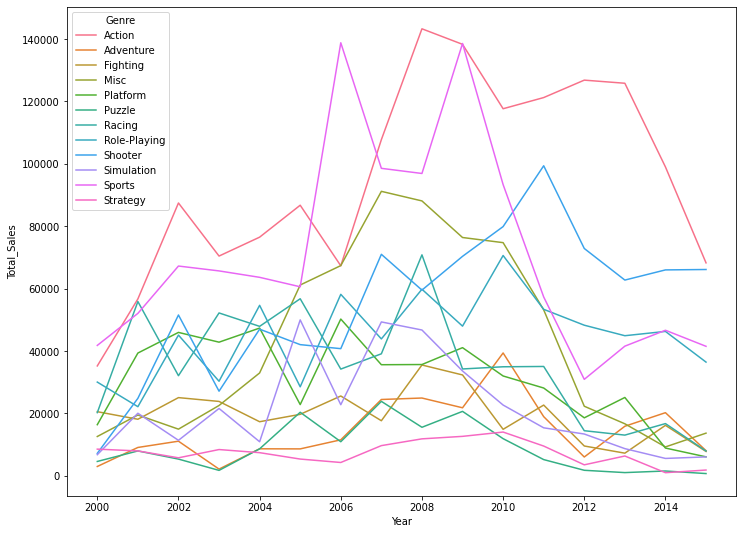

In [ ]:
plt.figure(figsize=[12, 9])
make_lineplot(df, min=2000, max=2015)
plt.show();

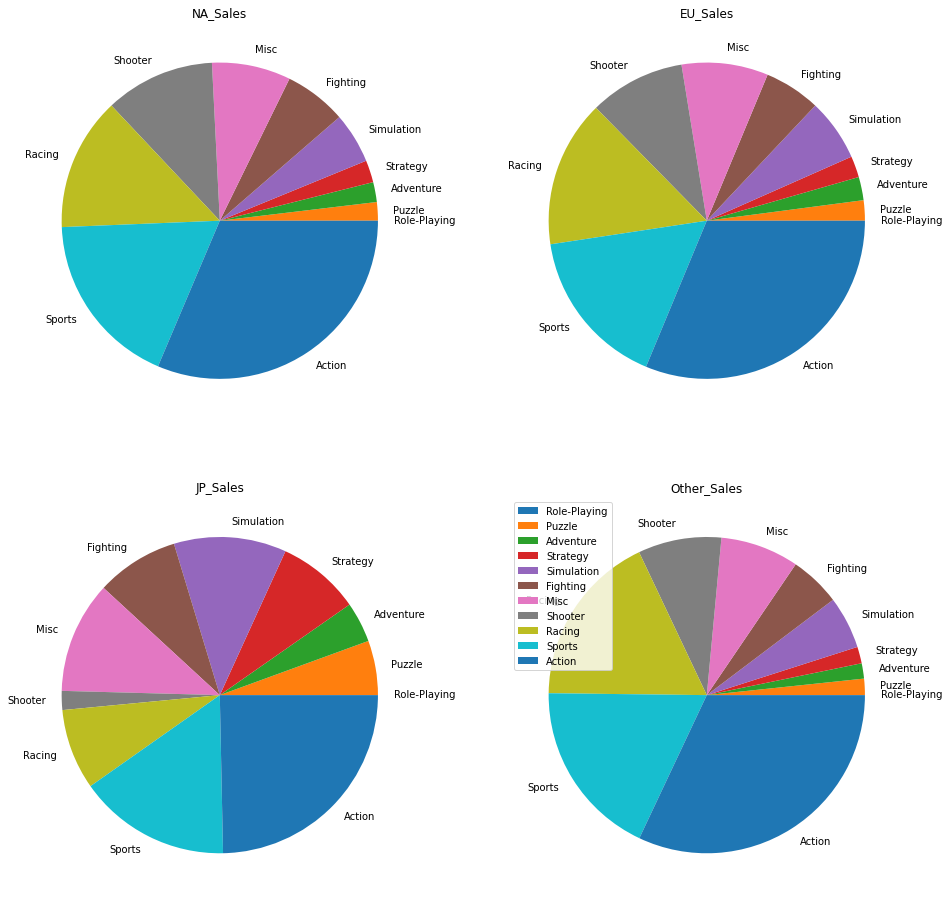

In [25]:
make_pie(df[df.Genre != 'Role-Playing'], min= 1999, max = 2005)

In [ ]:
def df_describe(df, idx, col, val='Total_Sales'):
 df_test = df.groupby([idx, col])[val].sum().reset_index()
 return df_test[df_test[val] > 0].pivot(index= idx, columns= col, values= val).describe().T.sort_values('mean', ascending= False)

In [30]:
df.groupby('Genre')['Total_Sales'].count(),df.groupby('Genre')['Total_Sales'].mean()

(Genre
 Action          4175
 Adventure       1307
 Fighting         837
 Misc            1609
 Puzzle           594
 Racing          1243
 Role-Playing    1464
 Shooter         1305
 Simulation       927
 Sports          2331
 Strategy         692
 Name: Total_Sales, dtype: int64, Genre
 Action           614.68503
 Adventure       221.644989
 Fighting        534.623656
 Misc            427.041641
 Puzzle          418.686869
 Racing          586.452132
 Role-Playing    629.603825
 Shooter         794.390805
 Simulation       497.72384
 Sports          568.309738
 Strategy        254.609827
 Name: Total_Sales, dtype: Float64)

In [43]:
def make_sample_mean(df, gen, per_min=2.5, per_max=97.5):
  df_sub = df.loc[df.Genre == gen, :]
  min = np.percentile(df_sub['Total_Sales'], per_min)
  max = np.percentile(df_sub['Total_Sales'], per_max)
  return np.mean(np.random.choice(
      df_sub.loc[(df.Total_Sales >= min) & (df.Total_Sales <= max)
        ,'Total_Sales']
      , size= 50))
  
def do_ttest(df):
  cols =df.columns
  dataset= [[scipy.stats.ttest_ind(df[x], df[y], alternative='greater').pvalue for y in cols] for x in cols]
  return pd.DataFrame(dataset, index=cols, columns=cols)

def make_score(df):
  return pd.DataFrame([
                       np.sum(np.where(df.T[col] <= 0.05, 1, 0)) for col in df.columns
  ], index= df.columns, columns= ['Score']).sort_values('Score', ascending=False)

In [23]:
np.random.seed(42)
df_stastic=pd.DataFrame([
                         [make_sample_mean(df[df.Year >=1995], ele, per_max = 82.5) for i in range(200)]\
                         for ele in df.Genre.unique()],\
                        index= df.Genre.unique()).T

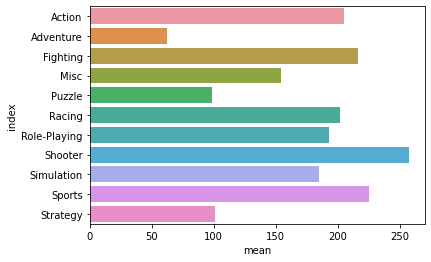

In [61]:
sns.barplot(data = df_stastic.describe().T.reset_index(), x='mean', y='index')
plt.show()

In [44]:
make_score(do_ttest(df_stastic))

,Score
Shooter,10
Sports,9
Fighting,8
Action,6
Racing,6
Role-Playing,5
Simulation,4
Misc,3
Strategy,2
Puzzle,1


In [66]:
df.Total_Sales.describe()
#df.loc[df.Name == r'SCORE International Baja 1000: The Official Game',:]

count    16484.000000
mean       539.248969
std       1560.047789
min          0.000000
25%         60.000000
50%        170.000000
75%        480.000000
max      82740.000000
Name: Total_Sales, dtype: float64

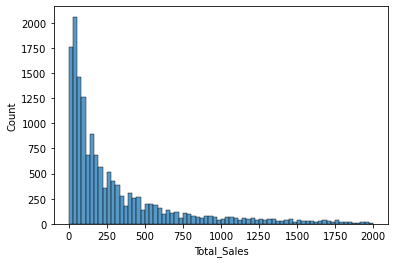

In [62]:
sns.histplot(data=df[df.Total_Sales<=2000], x= 'Total_Sales')
plt.show()

In [ ]:
df[df.Genre == 'Action'].groupby('Publisher')['Year'].count().reset_index().sort_values('Year', ascending= False)

,Publisher,Year
21,Activision,370
486,THQ,278
523,Ubisoft,264
345,Namco Bandai Games,262
85,Capcom,198
...,...,...
259,KID,0
258,Just Flight,0
257,Jorudan,0
255,Jester Interactive,0
